# Use Majorizer and Optimizing with Gradient Descent.

In [218]:
import torch
import torch.nn.functional as F
import torch.nn as nn

import numpy as np

import scipy.linalg as linalg
import PIL.Image as Image
import matplotlib.pyplot as plt
import time
from concurrent.futures import ThreadPoolExecutor

# Prepare Data

image shape: (32, 32, 3)


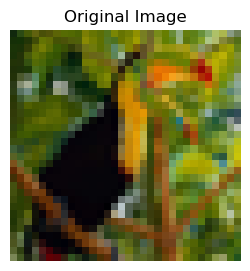

In [219]:
img = Image.open('img_002_SRF_2_LR.png')
img = img.resize((32,32),Image.BICUBIC)
img = np.asarray(img)
# normalize img
img = img/255.0

fig, axs = plt.subplots(1, 1, figsize=(3, 3))
axs.imshow(img)
axs.set_title('Original Image')
axs.axis('off')


print("image shape:", img.shape)

In [220]:
in_ch = 3
x_ch = 128
u_ch = 128
k_size = 7
max_iters = 200
k_c = np.random.rand(x_ch, in_ch, k_size, k_size)
k_b = np.random.rand(u_ch, x_ch, k_size, k_size)

C_conv = torch.FloatTensor(k_c)
B_conv = torch.FloatTensor(k_b)

C_conv = C_conv / (torch.sqrt(torch.sum(C_conv**2, dim=(1,2,3), keepdim=True))+1e-12)
B_conv = B_conv / (torch.sqrt(torch.sum(B_conv**2, dim=(1,2,3), keepdim=True))+1e-12)

print(C_conv.shape, B_conv.shape)

y = torch.FloatTensor(img).permute(2,0,1).unsqueeze(0)
Cy = F.conv2d(y, C_conv, padding = 3)
print(y.shape, Cy.shape)

torch.Size([128, 3, 7, 7]) torch.Size([128, 128, 7, 7])
torch.Size([1, 3, 32, 32]) torch.Size([1, 128, 32, 32])


In [221]:
def backtracking_line_search(f, grad_f, xk, pk, alpha=.1, rho=0.5, c=1e-2):
    """
    Backtracking line search to find the optimal step size.

    Args:
    f: The objective function.
    grad_f: The gradient of the objective function.
    xk: Current point.
    pk: Search direction.
    alpha: Initial step size.
    rho: Reduction factor.
    c: Condition constant.

    Returns:
    Optimal step size.
    """
    grad = grad_f(xk)
    const = torch.sum(grad*pk)
    fxk = f(xk)
    while f(xk + alpha * pk) > fxk + c * alpha * const:
        alpha *= rho
    return alpha

def loss_function(x):
    return torch.sum(torch.square(F.conv_transpose2d(x, C_conv, padding=3) - y)) + mu * torch.sum(torch.abs(x))

def gradient(x):
    return F.conv2d(F.conv_transpose2d(x, C_conv, padding=3) - y, C_conv, padding=3) + mu * torch.sign(x)


def GD(x0, mu, max_iter=max_iters, tol=1e-6):
    """
    Gradient descent algorithm.

    Args:
    x0: Initial point.
    mu: Regularization parameter.
    max_iter: Maximum number of iterations.
    tol: Tolerance.

    Returns:
    Optimal point.
    """
    x = x0
    loss_list = []
    for _ in range(max_iter):
        grad = gradient(x)
        alpha = backtracking_line_search(loss_function, gradient, x, -grad)
        x = x - alpha * grad
        loss = loss_function(x)
        loss_list.append(loss)
        if loss < tol:
            break
    return x, loss_list

def Adam(x0, mu, max_iter=max_iters, tol=1e-6, alpha=0.001, beta1=0.9, beta2=0.999, epsilon=1e-8):
    """
    Adam algorithm.

    Args:
    x0: Initial point.
    mu: Regularization parameter.
    max_iter: Maximum number of iterations.
    tol: Tolerance.
    beta1: Decay rate.
    beta2: Decay rate.
    epsilon: Small constant.

    Returns:
    Optimal point.
    """
    x = x0
    m = torch.zeros_like(x)
    v = torch.zeros_like(x)
    loss_list = []
    for t in range(1, max_iter + 1):
        grad = gradient(x)
        m = beta1 * m + (1 - beta1) * grad
        v = beta2 * v + (1 - beta2) * grad ** 2
        m_hat = m / (1 - beta1 ** t)
        v_hat = v / (1 - beta2 ** t)
        x = x - alpha * m_hat / (torch.sqrt(v_hat) + epsilon)
        loss = loss_function(x)
        loss_list.append(loss)
        if loss < tol:
            break
    return x, loss_list

def Momentum(x_init, mu, learning_rate=0.1, momentum=0.96, max_iters=max_iters, use_backtracking=True):
    x = x_init.clone()
    v = torch.zeros_like(x)
    loss_list = []

    for _ in range(max_iters):
        lookahead_x = x - momentum * v
        grad = gradient(lookahead_x)

        if use_backtracking:
            alpha = backtracking_line_search(loss_function, gradient, x, -grad)
        else:
            alpha = learning_rate

        v = momentum * v + alpha * grad
        x = x - v

        loss = loss_function(x)
        loss_list.append(loss.item())

    return x, loss_list

def FISTA(x0, mu, max_iter=max_iters):
    """
    FISTA algorithm.

    Args:
    x0: Initial point.
    mu: Regularization parameter.
    max_iter: Maximum number of iterations.
    tol: Tolerance.
    L: Lipschitz constant.

    Returns:
    Optimal point.
    """
    Rz = x0.clone()
    R = x0.clone()
    old_R = R.clone().detach()
    Rz.requires_grad = True
    R.requires_grad = True
    tkx = 1
    tk_1x = 1
    loss_list = []
    for i in range(max_iter):
        Lx = torch.ones((1, 1 ,1 ,1))
        pred_z = F.conv_transpose2d(Rz, C_conv, padding=3)
        const = ((y-pred_z)**2).sum((-1,-2,-3))
        const.sum().backward()
        const = const.data.clone().detach()
        grad_zk = (Rz.grad.data.clone().detach())
        stop_linesearch = torch.zeros((1, 1))
        zero_tensor = torch.zeros(Rz.shape)
        keep_going = 1
        
        while keep_going:
            gk = Rz - grad_zk/Lx
            R.data = (torch.sign(gk)*(torch.max((torch.abs(gk)-mu/Lx),zero_tensor))).clone() #soft thresholding
            pred = F.conv_transpose2d(R, C_conv, padding=3)
            temp1 = ((y - pred) ** 2).sum((-1,-2,-3))
            temp2 = const +((R - Rz)*grad_zk).sum((-1,-2,-3))+((Lx/2).sum((-1,-2,-3)))*(((R - Rz)**2).sum((-1,-2,-3)))
            stop_linesearch[temp1<= temp2] = True
            decay = torch.ones((1, 1))
            decay = (1-stop_linesearch)*2
            decay[decay==0] = 1
            Lx = Lx*decay.unsqueeze(-1).unsqueeze(-1)
            if (temp1.sum())<= (temp2.sum()):
                keep_going = 0

        loss_list.append(temp1.detach() + mu * torch.sum(torch.abs(R)).detach())
        tk_1x = 1+((((i+1))**8-1)/2) # the major contribution: Faster Fista step
        Rz.data = (R.clone().detach() + (tkx - 1)/(tk_1x)*(R.clone().detach() - old_R)).clone()
        old_R = R.clone().detach()
        tkx = tk_1x
        Rz.grad.zero_()
    return R, loss_list


# L-BFGS
def L_BFGS(x0, mu, max_iter=max_iters):
    """
    L-BFGS algorithm.

    Args:
    x0: Initial point.
    mu: Regularization parameter.
    max_iter: Maximum number of iterations.

    Returns:
    Optimal point.
    """
    x = x0
    loss_list = []
    for _ in range(max_iter):
        loss = loss_function(x)
        grad = gradient(x)
        
        q = grad.clone()
        alpha_list = []
        s = []
        y = []
        rho = []
        for i in range(len(s) - 1, -1, -1):
            alpha_i = rho[i] * torch.sum(s[i] * q)
            q = q - alpha_i * y[i]
            alpha_list.append(alpha_i)
            
        # hessian-vector product
        r = q
        for i in range(len(s)):
            beta = rho[i] * torch.sum(y[i] * r)
            r = r + s[i] * (alpha_list[i] - beta)
            
        p = -r
        alpha = 0.1
        while True:
            x_new = x + alpha * p
            loss_new = loss_function(x_new)
            if loss_new < loss:
                break
            alpha *= 0.5
        
        # update x
        s_new = x_new - x
        x = x_new
        
        # compute new gradient
        new_grad = gradient(x)
        y_new = new_grad - grad
        
        # update history
        if len(s) == 20:
            s.pop(0)
            y.pop(0)
            rho.pop(0)
        s.append(s_new)
        y.append(y_new)
        rho.append(1 / torch.sum(y_new * s_new))
        
        loss_list.append(loss)
        
    return x, loss_list

def recon(x):
    return F.conv_transpose2d(x, C_conv, padding=3)

In [222]:
x0 = torch.zeros(1, x_ch, 32, 32)
mu = 0.1
x_gd, loss_gd = GD(x0, mu)
x_FISTA, loss_FISTA = FISTA(x0, mu)
x_adam, loss_adam = Adam(x0, mu)
x_mom, loss_mom = Momentum(x0, mu)
x_LBFGS, loss_LBFGS = L_BFGS(x0, mu)

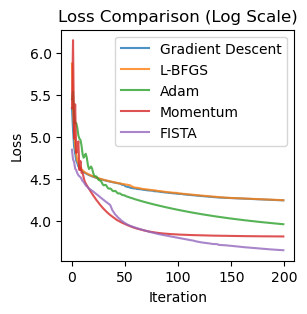

In [223]:
plt.figure(figsize=(3, 3))

plt.plot(np.log(loss_gd), label='Gradient Descent', alpha=0.8)
plt.plot(np.log(loss_LBFGS), label='L-BFGS', alpha=0.8)
plt.plot(np.log(loss_adam), label='Adam', alpha=0.8)
plt.plot(np.log(loss_mom), label='Momentum', alpha=0.8)
plt.plot(np.log(loss_FISTA), label='FISTA', alpha=0.8)

plt.xlabel('Iteration')
plt.ylabel('Loss')
plt.legend()
plt.title('Loss Comparison (Log Scale)')
plt.show()

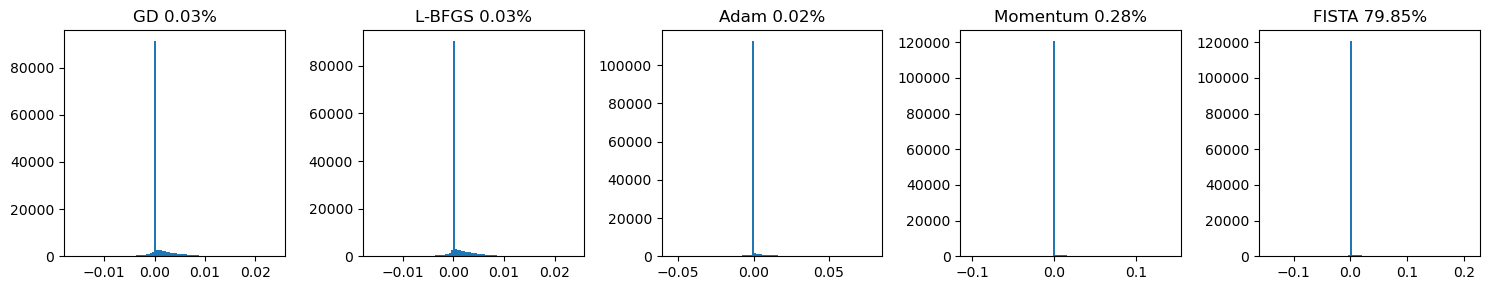

In [224]:
# plot the histograms of the x_gd and x_adam and put them on separate subplots
fig, axs = plt.subplots(1, 5, figsize=(15, 3))
axs[0].hist(x_gd.flatten().detach().numpy(), bins=100)
axs[0].set_title('GD {:.2f}%'.format(torch.sum(torch.abs(x_gd)<1e-8).item()/x_gd.numel()*100))
axs[1].hist(x_LBFGS.flatten().detach().numpy(), bins=100)
axs[1].set_title('L-BFGS {:.2f}%'.format(torch.sum(torch.abs(x_LBFGS)<1e-8).item()/x_LBFGS.numel()*100))
axs[2].hist(x_adam.flatten().detach().numpy(), bins=100)
axs[2].set_title('Adam {:.2f}%'.format(torch.sum(torch.abs(x_adam)<1e-8).item()/x_adam.numel()*100))
axs[3].hist(x_mom.flatten().detach().numpy(), bins=100)
axs[3].set_title('Momentum {:.2f}%'.format(torch.sum(torch.abs(x_mom)<1e-8).item()/x_mom.numel()*100))
axs[4].hist(x_FISTA.flatten().detach().numpy(), bins=100)
axs[4].set_title('FISTA {:.2f}%'.format(torch.sum(torch.abs(x_FISTA)<1e-8).item()/x_FISTA.numel()*100))
plt.tight_layout()
plt.show()


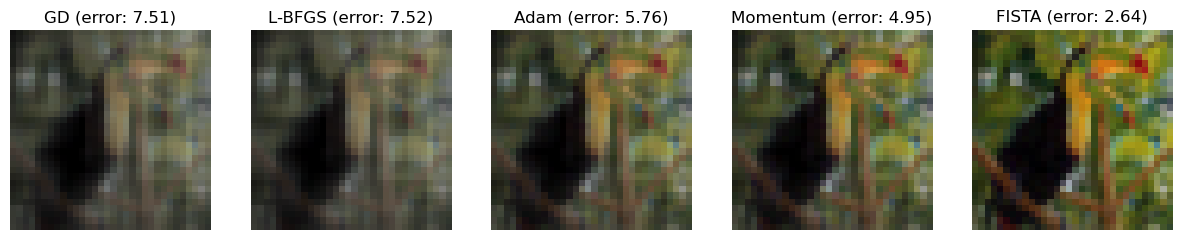

In [225]:
# reconstruct the image and compare
recon_gd = recon(x_gd).squeeze().permute(1,2,0).detach().numpy()
recon_LBFGS = recon(x_LBFGS).squeeze().permute(1,2,0).detach().numpy()
recon_adam = recon(x_adam).squeeze().permute(1,2,0).detach().numpy()
recon_ngd = recon(x_mom).squeeze().permute(1,2,0).detach().numpy()
recon_FISTA = recon(x_FISTA).squeeze().permute(1,2,0).detach().numpy()

# calculate L2 norm of the difference and set as titles
l2_gd = np.linalg.norm(img - recon_gd)
l2_adam = np.linalg.norm(img - recon_adam)
l2_BFGS = np.linalg.norm(img - recon_LBFGS)
l2_ngd = np.linalg.norm(img - recon_ngd)
l2_FISTA = np.linalg.norm(img - recon_FISTA)

fig, axs = plt.subplots(1, 5, figsize=(15, 3))
axs[0].imshow(recon_gd.clip(0,1))
axs[0].set_title('GD (error: {:.2f})'.format(l2_gd))
axs[0].axis('off')
axs[1].imshow(recon_LBFGS.clip(0,1))
axs[1].set_title('L-BFGS (error: {:.2f})'.format(l2_BFGS))
axs[1].axis('off')
axs[2].imshow(recon_adam.clip(0,1))
axs[2].set_title('Adam (error: {:.2f})'.format(l2_adam))
axs[2].axis('off')
axs[3].imshow(recon_ngd.clip(0,1))
axs[3].set_title('Momentum (error: {:.2f})'.format(l2_ngd))
axs[3].axis('off')
axs[4].imshow(recon_FISTA.clip(0,1))
axs[4].set_title('FISTA (error: {:.2f})'.format(l2_FISTA))
axs[4].axis('off')
plt.show()

# Gradient of Majorizer
### Diagonal Matrix $ W $

Given the vector $ x = \begin{bmatrix} x_1 \\ x_2 \\ \vdots \\ x_n \end{bmatrix} $, the diagonal matrix $ W $ is:

$ W = \text{diag} \left( \frac{\mu}{|x_1|}, \frac{\mu}{|x_2|}, \ldots, \frac{\mu}{|x_n|} \right) $

For a vector $ x $ of size 3, $ W $ looks like:

$
W = \begin{bmatrix}
\frac{\mu}{|x_1|} & 0 & 0 \\
0 & \frac{\mu}{|x_2|} & 0 \\
0 & 0 & \frac{\mu}{|x_3|}
\end{bmatrix}
$

### Gradient Vector $ \mu\,\text{sign}(x) $

The gradient of the function $ f(x) = \frac{1}{2} x^\top W x $ is:

$
\nabla_x f(x) = \mu\,\text{sign}(x)
$

For the same vector $ x $ of size 3, where the sign function is applied element-wise:

$
\text{sign}(x) = \begin{bmatrix}
\text{sign}(x_1) \\
\text{sign}(x_2) \\
\text{sign}(x_3)
\end{bmatrix}
$

# L1 norm gradient

### L1 Norm Definition

For $ x \in \mathbb{R}^n $, the L1 norm is:

$ \|x\|_1 = \sum_{i=1}^n |x_i| $

### Subgradient of the L1 Norm

The subgradient of $\|x\|_1$ with respect to $x_i$ is:

$
\frac{\partial \|x\|_1}{\partial x_i} = \text{sign}(x_i)
$

where the sign function $\text{sign}(x_i)$ is defined as:

$
\text{sign}(x_i) = \begin{cases} 
1 & \text{if } x_i > 0 \\
-1 & \text{if } x_i < 0 \\
\text{any value in } [-1, 1] & \text{if } x_i = 0 \text{ by subgradient}
\end{cases}
$

In vector form, the subgradient vector is:

$
\nabla_x \|x\|_1 = \text{sign}(x)
$

# Analysis

The L1 norm, $\|x\|_1 = \sum_i |x_i| $, is not smooth at 0. This poses challenges for gradient-based methods.

Here’s why in the Literature, people often use algorithms like FISTA or iterative hard thresholding instead of simple gradient descent:

### 1. **Gradient of L1 Norm**

- **Gradient Descent with Subdifferential:** At points where $x_i \neq 0$, the gradient of the L1 norm is straightforward: it is $\text{sign}(x_i)$. However, at $x_i = 0$, the L1 norm is not differentiable, but it does have a subdifferential, which includes all values in the interval $[-1, 1]$. 

Simply setting the gradient to 0 at these points is not generally effective because it does not capture the potential direction for improvement.

### 2. **Convergence and Efficiency**

- **Gradient Descent Limitations:** Gradient descent applied to problems involving L1 norms can struggle with convergence and efficiency. The step size needs careful tuning, and the non-smooth nature of the L1 norm can make it hard for the algorithm to make meaningful progress near zero.